In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# DDO 165

(706, 676)


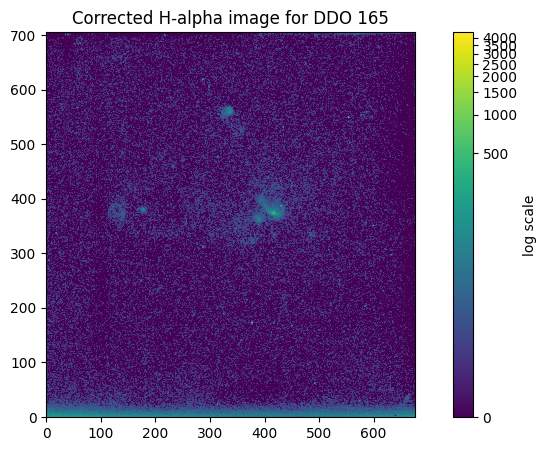

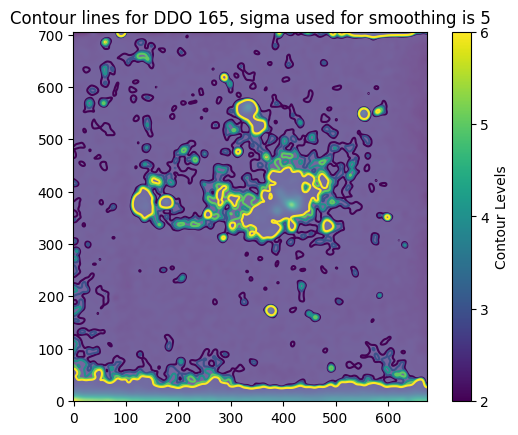

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from astropy.io import fits


# Load the data
galaxy_name = "DDO 165"
DDO165_H = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 165\d165hmrms.fits")
DDO165_V = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 165\non_shifted_background_d165v.fits")
print(np.shape(DDO165_H))

# Plot the corrected image
DDO165_H = DDO165_H
ltf.log_scale_plot(DDO165_H, f"Corrected H-alpha image for {galaxy_name}", "log scale")

# Define the smoothing sigma
sigma = 5

# Create the Gaussian smoothed image
smoothed = gaussian_filter(DDO165_H, sigma)

fig, ax = plt.subplots()
im = ax.imshow(smoothed, alpha=0.75, origin="lower")

# Create the contour plot
levels = [2, 3, 4, 5, 6]
CS = ax.contour(smoothed, levels, cmap='viridis')

# Create a custom color bar for the contour lines
norm = Normalize(vmin=2, vmax=6)  # Adjust this range according to your contour levels
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add the color bar with labels
cbar = fig.colorbar(sm, ax=ax, ticks=levels)
cbar.ax.set_yticklabels([str(level) for level in levels])
cbar.set_label('Contour Levels')

plt.title(f"Contour lines for {galaxy_name}, sigma used for smoothing is {sigma}")
plt.show()

# Specify the output directory and file name
output_dir = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d165"
output_path = os.path.join(output_dir, f"{galaxy_name}_replaced.fits")

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the replaced array to a new FITS file
fits.writeto(output_path, DDO165_H.astype(np.float32), overwrite=True)


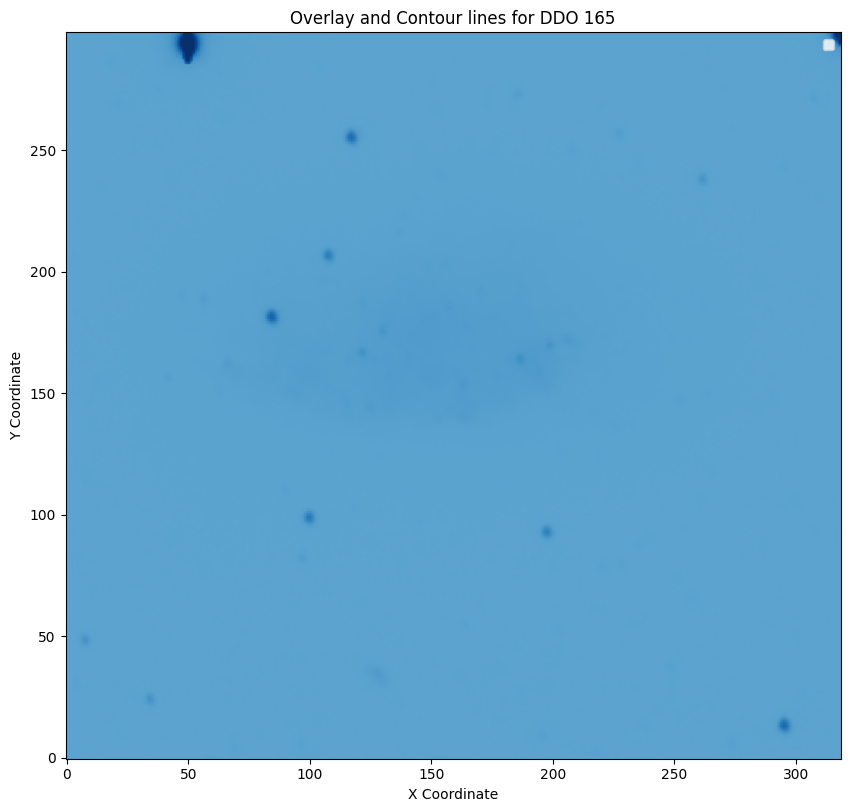

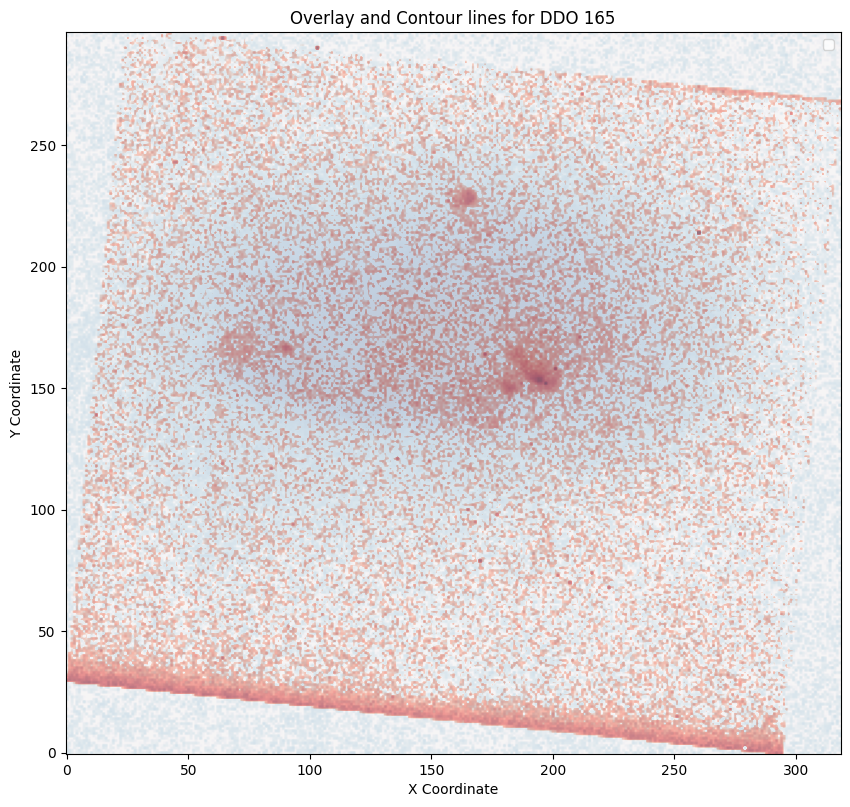

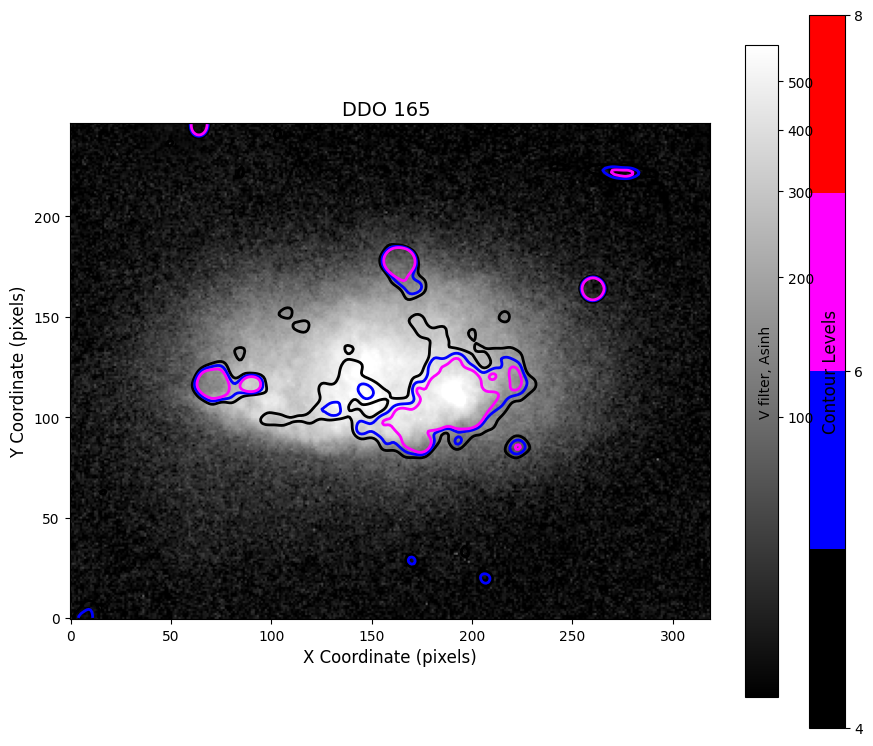

H-alpha pixelscale: 0.4714933788254607


In [3]:
def V_and_Halpha_alignment_no_headers(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.5):
    norm = ImageNormalize(vmin=0., stretch=LogStretch())

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Function to open FITS file and handle endian issues
    def open_fits_file(file_path):
        with fits.open(file_path) as hdul:
            data = hdul[0].data
            if data.dtype.byteorder == '>':
                data = data.byteswap().newbyteorder()
        return data

    # Open FITS files and get data
    V_image = open_fits_file(image1_path)
    H_image = open_fits_file(image2_path)

    # Calculate the affine transformation matrix using the star coordinates
    tform = AffineTransform()
    tform.estimate(star_coords_H, star_coords_V)

    # Apply the affine transformation to the H_image
    aligned_H_image = warp(H_image, inverse_map=tform.inverse, output_shape=V_image.shape)

    # Save the aligned image to a new FITS file without headers
    aligned_H_image_path = os.path.join(output_dir, 'aligned_d101ha_no_headers.fits')
    fits.writeto(aligned_H_image_path, aligned_H_image.astype(np.float32), overwrite=True)

    # Create a mask for the overlapping region
    overlap_mask = (aligned_H_image > 0) & (V_image > 0)

    # Find the bounding box of the overlapping region
    coords = np.argwhere(overlap_mask)
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Crop the images to the bounding box
    aligned_H_image_cropped = aligned_H_image[x_min:x_max+1, y_min:y_max+1]
    V_image_cropped = V_image[x_min:x_max+1, y_min:y_max+1]

    # Save the cropped images as new FITS files without headers
    V_image_cropped_path = os.path.join(output_dir, f'cropped_{galaxy_name}_V_no_headers.fits')
    aligned_H_image_cropped_path = os.path.join(output_dir, f'cropped_{galaxy_name}_H_no_headers.fits')
    fits.writeto(V_image_cropped_path, V_image_cropped.astype(np.float32), overwrite=True)
    fits.writeto(aligned_H_image_cropped_path, aligned_H_image_cropped.astype(np.float32), overwrite=True)

    # Plot the cropped images on top of each other
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(V_image_cropped, cmap='Blues', alpha=alpha1, norm=norm, origin="lower")
    ax.imshow(aligned_H_image_cropped, cmap='Reds', alpha=alpha2, norm=norm, origin="lower")

    plt.title(f"Overlay and Contour lines for {galaxy_name}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend([f"{galaxy_name} V filter", f'{galaxy_name} H-alpha filter'])
    plt.show()

    return V_image_cropped, aligned_H_image_cropped


image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 165\d165v.fits"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 165\d165ha.fits"
output_dir_star = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d165\withstar"
output_dir = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d165"
star_coords_V = np.array([[529,349], [431,364], [416, 437]])
star_coords_H = np.array([[437,220], [211,233], [162, 419]])

V_with_stars, H_with_stars = V_and_Halpha_alignment_no_headers(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir_star, alpha1=1, alpha2=0)


image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 165\non_shifted_background_d165v.fits"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d165\DDO 165_replaced.fits"
V_pixelscale = 1.134
V_image , H_image = V_and_Halpha_alignment_no_headers(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.5)
ltf.plot_contours_V_and_Halpha(galaxy_name, V_image[50:], H_image[50:], folder_path=r"C:\Users\AYSAN\Desktop\project\Galaxy\H-alpha regions", alpha=1, sigma=3, contour_levels=[4,6,8])
H_pixelscale = ltf.calculate_pixelscale(star_coords_V, star_coords_H, V_pixelscale)
print("H-alpha pixelscale:", H_pixelscale)

Text(0, 0.5, 'Y Coordinate')

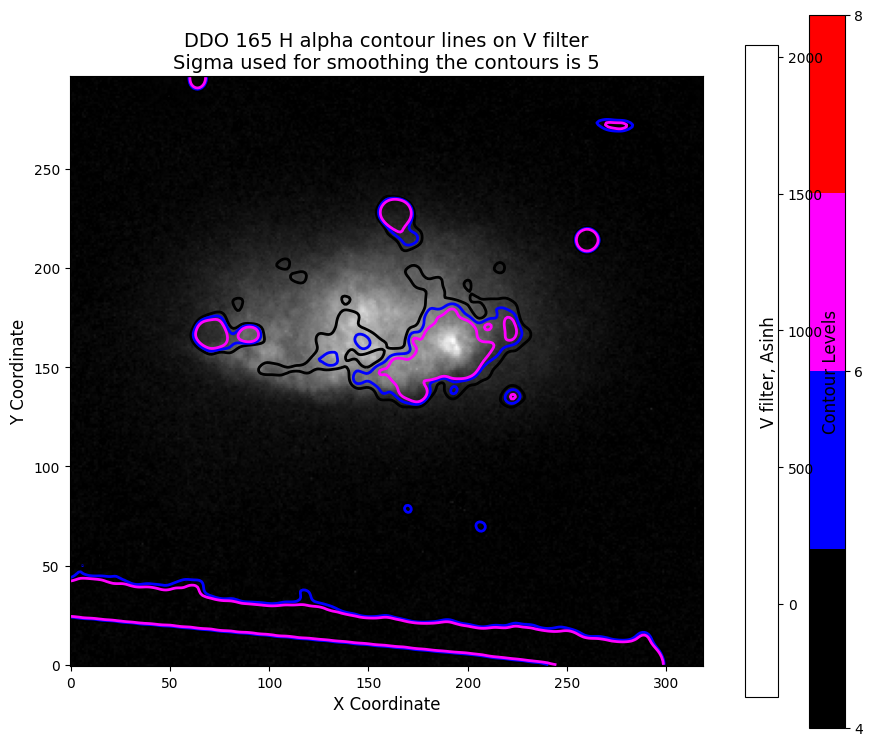

In [4]:
from matplotlib.colors import Normalize, ListedColormap
contour_levels = [4,6,8]
# Define colors for contours
contour_colors = ['black', 'blue', 'magenta', 'red']
V = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d165\withstar\cropped_DDO 165_V_no_headers.fits")
# Plot the V filter image with enhanced contrast
fig, ax = plt.subplots(figsize=(10, 10))
im1 = ax.imshow(H_image, cmap='gray', alpha=0, origin="lower")
im2 = ax.imshow(V_image, cmap='gray', alpha=1, origin="lower")
# Create the Gaussian smoothed image for contours
smoothed = gaussian_filter(H_image, sigma=3)

# Add contours of the smoothed image with specific colors and line styles
for i, level in enumerate(contour_levels):
    ax.contour(smoothed, levels=[level], colors=contour_colors[i], linestyles='solid', linewidths=2)

# Create a custom color bar with lines
cmap = ListedColormap(contour_colors)
norm = Normalize(vmin=min(contour_levels), vmax=max(contour_levels))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the color bar with labels
cbar_contour = fig.colorbar(sm, ax=ax, ticks=contour_levels, fraction=0.046, pad=0.04)


cbar_contour.set_label('Contour Levels', labelpad=-30, fontsize=12)

# Add colorbar for the V filter image
cbar1 = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.06)
cbar1.set_label("V filter, Asinh", labelpad=-45, fontsize=12)

# Set larger font sizes for titles and labels
ax.set_title(f"{galaxy_name} H alpha contour lines on V filter\nSigma used for smoothing the contours is {sigma}", fontsize=14)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)


# Resolution DDO 168

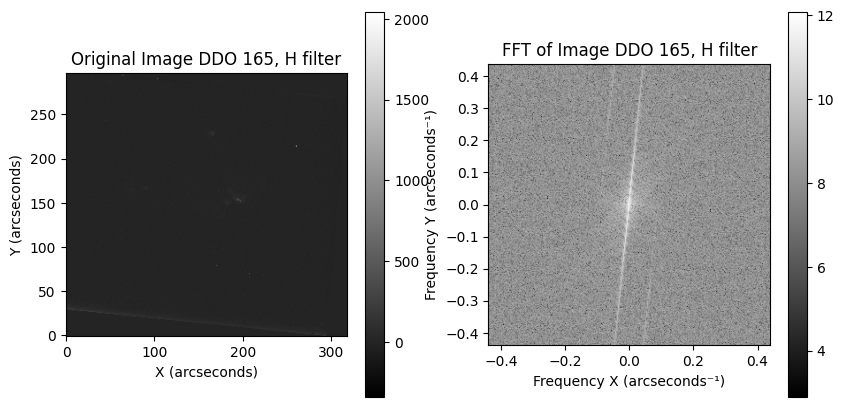

ValueError: not enough values to unpack (expected 3, got 2)

In [5]:
ltf.resolution_profiles(H_image, V_image, galaxy_name, V_pixelscale, r"C:\Users\AYSAN\Desktop\project\Galaxy\Resolution")